In [1]:
%load_ext autoreload
%autoreload 2

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [2]:
import matplotlib.pyplot as plt
import numpy as np


In [3]:
%matplotlib inline
fig_width_pt = 525  # Get this from LaTeX using \showthe\columnwidth
fig_width_pt = 618  # Get this from LaTeX using \showthe\columnwidth
fig_width_pt = 1024  # Get this from LaTeX using \showthe\columnwidth
ppi = 72.27 # (constant) definition of the ppi = points per inch
inches_per_pt = 1.0/ppi  # Convert pt to inches
#inches_per_cm = 1./2.54
figwidth = fig_width_pt*inches_per_pt  # width in inches
phi = (np.sqrt(5) + 1. ) /2 # golden ratio is good for your eyes

In [4]:
figname = '../paper/fig_intro'

# display images

#### MNIST dataset read out

In [5]:
from retina import get_data_loader

In [6]:
loader = get_data_loader(batch_size=100, train=False)

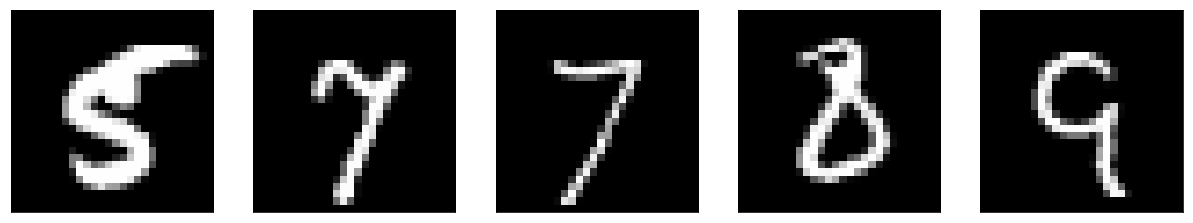

In [7]:
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 5))
for ax in axs:
    data, label = next(iter(loader))
    ax.imshow(data[0, 0, :, :], cmap=plt.gray())
    ax.set_xticks([])
    ax.set_yticks([])


In [8]:
N_pic = 128

minibatch_size = 100  # quantity of examples that'll be processed
lr = 1e-4 #1e-3  #0.05

OFFSET_STD = 40 #
OFFSET_MAX = 30 #
NOISE = 1. #0 #
CONTRAST = 0.4 #1 #
sf_0 = 0.2
B_sf = 0.3

In [9]:
from retina import minmax, place_object

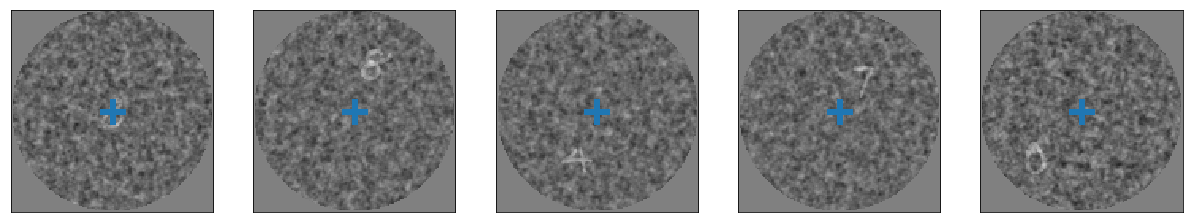

In [10]:
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 8))
for ax in axs:
    data, label = next(iter(loader))
    offset_std = OFFSET_STD
    offset_max = OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    data_fullfield = place_object(data[0, 0, :, :].numpy(), i_offset, j_offset,  N_pic=N_pic,
                                    CONTRAST=CONTRAST, NOISE=NOISE,
                                    sf_0=sf_0, B_sf=B_sf)
    ax.imshow(data_fullfield, cmap=plt.gray(), vmin=0, vmax=1)
    ax.plot([N_pic//2], [N_pic//2], '+', ms=26, markeredgewidth=6)
    ax.set_xticks([])
    ax.set_yticks([])

In [11]:
data_fullfield.min(), data_fullfield.max()

(0.15160021936679197, 0.7704911371122272)

In [12]:
data, label = next(iter(loader))
offset_std = OFFSET_STD
offset_max = OFFSET_MAX
i_offset = minmax(np.random.randn() * offset_std, offset_max)
j_offset = minmax(np.random.randn() * offset_std, offset_max)
data_fullfield = place_object(data[0, 0, :, :].numpy(), i_offset, j_offset,  N_pic=N_pic,
                                CONTRAST=CONTRAST, NOISE=NOISE,
                                sf_0=sf_0, B_sf=B_sf)
print('i_offset', i_offset)
print('j_offset', j_offset)


i_offset 30
j_offset 18


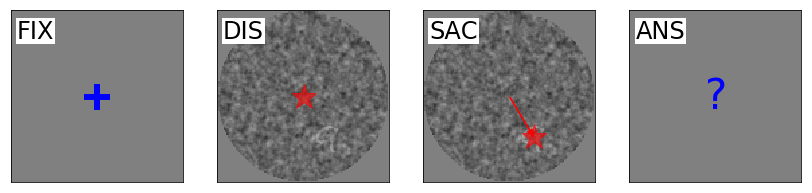

In [45]:
texts = ['FIX', 'DIS', 'SAC', 'ANS']
def panel_A(fig_A=None, axs_A=None):

    N_plot = 4

    if fig_A is None:
        fig_A, axs_A = plt.subplots(1, N_plot, figsize = (figwidth, figwidth/4))
    for ax, text in zip(axs_A, texts):
        ax.imshow(.5 + np.zeros_like(data_fullfield), cmap=plt.gray(), vmin=0, vmax=1)
        if text=='FIX': 
            ax.plot([N_pic//2], [N_pic//2], '+', color='b', ms=26, markeredgewidth=6)
        elif text in ['DIS', 'SAC']: 
            ax.imshow(data_fullfield, cmap=plt.gray(), vmin=0, vmax=1)
            opts = dict(ms=26, markeredgewidth=1, alpha=.6)
            if text == 'DIS':
                ax.plot([N_pic//2], [N_pic//2], '*r', **opts)
            else:
                ax.plot([N_pic//2+j_offset], [N_pic//2+i_offset], '*r', **opts)
                ax.arrow(N_pic//2, N_pic//2, j_offset, i_offset, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
        elif text=='ANS':         
            ax.text(N_pic//2, N_pic//2, '?', color='b', fontsize=42,
              ha='center', va='center')

        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(4, 15, text, fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center') 

    # TODO: show arrow of time
    #fig.arrow(N_pic//2, N_pic//2, j_offset - 4 * N_pic, i_offset, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
    return fig_A, axs_A
fig_A, axs_A = panel_A()
#fig_A.savefig(figname + '.pdf')

# foveation

In [46]:
N_theta = 6
N_azimuth = 16
N_eccentricity = 10
N_phase = 2
N_X = 128
N_Y = 128
rho = 1.41
verbose = 1


In [47]:
from retina import vectorization

retina_transform = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)

In [30]:
from retina import  retina, retina_inverse
retina_inverse_transform = retina_inverse(retina_transform)

In [31]:
data_retina, tensor_retina   = retina(data_fullfield, retina_transform)


#### Full encoding

In [32]:
retina_transform = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)
print(retina_transform.shape)

(6, 16, 10, 2, 16384)


In [33]:
retina_vector = retina_transform.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
print(retina_vector.shape)

(1920, 16384)


In [34]:
retina_inverse = np.linalg.pinv(retina_vector)
print(retina_inverse.shape)

(16384, 1920)


In [35]:
data_fullfield_0 = place_object(data[0, 0, :, :].numpy(), 0, 0,  N_pic=N_pic,
                                CONTRAST=CONTRAST, NOISE=NOISE,
                                sf_0=sf_0, B_sf=B_sf)

data_retina_0, tensor_retina   = retina(data_fullfield_0, retina_transform)
im_0 = retina_inverse_transform @ data_retina_0
im_0 = im_0.reshape((N_pic, N_pic))

data_retina, tensor_retina   = retina(data_fullfield, retina_transform)
im = retina_inverse_transform @ data_retina
im = im.reshape((N_pic, N_pic))


In [36]:
im_0.shape

(128, 128)

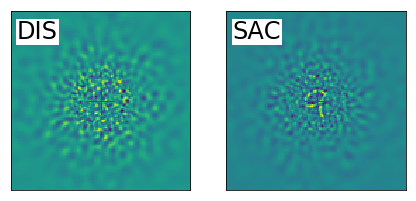

In [42]:
def panel_B(fig_B=None, axs_B=None):
    if fig_B is None:
        fig_B, axs_B = plt.subplots(1, 2, figsize=(figwidth/2, figwidth/phi/2))
    for ax, text in zip(axs_B, texts[1:3]):
        opts = dict(ms=26, markeredgewidth=1, alpha=.6)
        if text == 'DIS':
            ax.imshow(im, cmap=plt.viridis())
            ax.plot([N_pic//2], [N_pic//2], '+g', **opts)
        else:
            ax.imshow(im_0, cmap=plt.viridis())
            ax.plot([N_pic//2], [N_pic//2], '+g', **opts)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.plot([N_pic//2], [N_pic//2], '+', color='r', ms=26, markeredgewidth=1)
        ax.text(4, 15, text, fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center') 

    return fig_B, axs_B
fig_B, axs_B = panel_B()
# fig_B.savefig(figname + '.pdf')

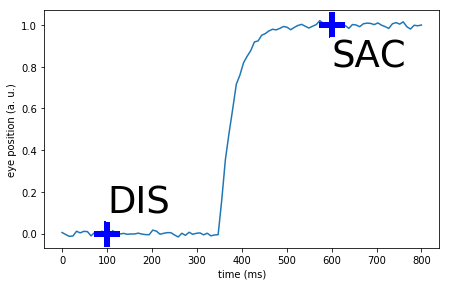

In [43]:
def panel_C(fig_C=None, axs_C=None, N_time=100, offset=.15):
    if fig_C is None:
        fig_C, axs_C = plt.subplots(1, 1, figsize=(figwidth/2, figwidth/phi/2))
    
    time = np.linspace(0, 800, N_time)
    latency = 350
    EM = 1. - np.exp(- (time-latency) / 32. ) 

    EM[time<latency] = 0
    EM += .01 * np.random.randn(N_time)

    axs_C.plot(time, EM)
    axs_C.plot([100], [0], '+', color='b', ms=26, markeredgewidth=6)
    axs_C.plot([600], [1], '+', color='b', ms=26, markeredgewidth=6)
    opts = dict(fontsize=37,
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
          ha='left', va='center')
    axs_C.text(100, offset, 'DIS', **opts)
    axs_C.text(600, 1-offset, 'SAC', **opts)
    axs_C.set_xlabel('time (ms)')
    axs_C.set_ylabel('eye position (a. u.)')
    # fig_B.savefig(figname + '.pdf')
    return fig_C, axs_C

fig_C, axs_C = panel_C()

# summary

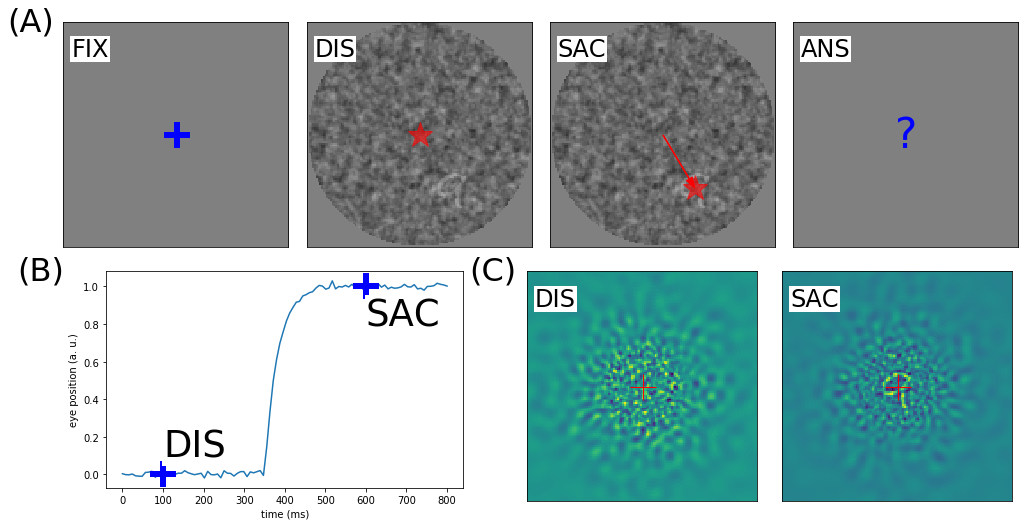

In [48]:
# fig = plt.figure(figsize = (21, 13))
fig, axs = plt.subplots(2, 4, figsize = (figwidth, figwidth/2), constrained_layout=True)
    
fig, axs_A = panel_A(fig_A=fig, axs_A=axs[0])
fig, axs_B = panel_B(fig_B=fig, axs_B=axs[1][1:3])
fig, axs_C = panel_C(fig_C=fig, axs_C=axs[1][0])
axs[1][3].remove()
# pos : [left, bottom, width, height] =    The new position of the in `.Figure` coordinates.
axs_C.set_position([0.1, 0.05, .35, 0.425])
axs_B[0].set_position([0.4, .025, .45, .45])
axs_B[1].set_position([0.65, .025, .45, .45])
offset = -.25
for ax, text, x, y in [[axs_A[0], 'A', offset, 1], [axs_C, 'B', offset, 1], [axs_B[0], 'C', offset, 1]]:
    ax.text(x, y, '(' + text + ')', fontsize=32,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 

#plt.tight_layout()
fig.savefig(figname + '.pdf')

#### Orientation invariant power encoding (colliculus??)

In [40]:
colliculus = (retina_transform**2).sum(axis=(0, 3))
#colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

(16, 10, 16384)


In [41]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

(160, 16384)


In [ ]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

In [ ]:
energy = (retina**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_azimuth):
    for i_scale in range(N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/N_azimuth)])
fig.suptitle('Tiling of visual space using energy', y=1.02)
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

# post-processing

In [ ]:
!ls  -l {figname}*

In [ ]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))